# Captain Agent
By: Linxin Song, Jiale Liu, Jieyu Zhang

In this notebook, we introduce CaptainAgent, an agent enhanced with the capability to call AutoBuild to break down and solve complex tasks. AutoBuild can initiate a nested chat between a group of experts and converse to solve the task. The experts in nested chat can be retrieved from agent library. The agents can be equipped with tools for advanced coding. In addition to agent library, we release a tool library that can assist with advanced tasks.

````{=mdx}
:::info Requirements
Install `pyautogen`:
```bash
pip install pyautogen[autobuild]
```

For more information, please refer to the [installation guide](/docs/installation/).
:::
````

## Setup API endpoint
In order to setup API, you should create a OAI_CONFIG_LIST file. The config list should look like the following:
```python
config_list = [
    {
        'model': 'gpt-4-1106-preview',
        'api_key': '<your OpenAI API key here>',
    },
    {
        'model': 'gpt-3.5-turbo',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2024-02-15-preview',
    },
    {
        'model': 'gpt-3.5-turbo-16k',
        'api_key': '<your Azure OpenAI API key here>',
        'base_url': '<your Azure OpenAI API base here>',
        'api_type': 'azure',
        'api_version': '2024-02-15-preview',
    },
]
```

````{=mdx}
:::tip
Learn more about configuring LLMs for agents [here](/docs/topics/llm_configuration).
:::
````

In [1]:
import autogen

config_file_or_env = "OAI_CONFIG_LIST"
llm_config = {"temperature": 0}
config_list = autogen.config_list_from_json(
    config_file_or_env, filter_dict={"model": ["gpt-4-1106", "gpt-4"]}
)  # You can modify the filter_dict to select the models

## Using CaptainAgent without Retrieval
We begin with demonstrating how to use CaptainAgent without retrieval. In this case, the experts needed for task solving will be identified and generated by LLM, then put into a nested chat to converse.

In [3]:
from autogen.agentchat.contrib.captain_agent import CaptainAgent
from autogen.agentchat.contrib.captain_user_proxy_agent import CaptainUserProxyAgent

general_llm_config = {
    "temperature": 0,
    "config_list": autogen.config_list_from_json("OAI_CONFIG_LIST", filter_dict={"model": ["gpt-4-1106-preview"]}),
}

nested_mode_config = {
    "autobuild_init_config": {
        "config_file_or_env": "OAI_CONFIG_LIST",
        "builder_model": "gpt-4-1106-preview",
        "agent_model": "gpt-4-1106-preview",
    },
    # this is used to configure the autobuild building process
    "autobuild_build_config": {
        "default_llm_config": {"temperature": 1, "top_p": 0.95, "max_tokens": 1500, "seed": 52},
        # this is used to configure the user proxy within nested chat
        "code_execution_config": {"timeout": 300, "work_dir": "groupchat", "last_n_messages": 1},
        "coding": True,
    },
    "group_chat_config": {"max_round": 15},
    "group_chat_llm_config": general_llm_config.copy(),
}

## build agents
meta_agent = CaptainAgent(name="meta_agent", llm_config=general_llm_config, nested_mode="autobuild")
meta_user_proxy = CaptainUserProxyAgent(
    name="meta_user_proxy",
    nested_mode_config=nested_mode_config,
    code_execution_config={"use_docker": False},  # you can modify the setting
    agent_config_save_path=None,  # If you'd like to save the created agents in nested chat for further use, specify the path here
)

In [4]:
result = meta_user_proxy.initiate_chat(
    meta_agent,
    message="Let's play game of 24. Given 4 numbers, you need to use +, -, *, / to get 24. The numbers are 2, 2, 7, 12.",
)

meta_user_proxy (to meta_agent):

Let's play game of 24. Given 4 numbers, you need to use +, -, *, / to get 24. The numbers are 2, 2, 7, 12.

--------------------------------------------------------------------------------
meta_agent (to meta_user_proxy):

***** Suggested tool call (call_AQ8obghzisWBJfuG7O4lqlRx): seek_experts_help *****
Arguments: 
{
  "group_name": "GameOf24Solver",
  "building_task": "- Mathematician: An expert in mathematics who can analyze and combine numbers using various operations to achieve a target result.\n- Algorithm Designer: A specialist in creating algorithms to systematically explore all possible combinations of operations and numbers to find a solution to a given problem.\n- Checker: A professional who verifies the correctness of the solution provided by the other experts, ensuring that the operations lead to the desired result without any errors.",
  "execution_task": "## Task description\nThe task is to find a way to combine the numbers 2, 2, 7, 12 u

## Building Agents from library & Retrieve tools from tool library
One significant feature of CaptainAgent is that the experts and tools can be retrieved from a dedicated library.

`captainagent_expert_library.json` contains examples of experts. You can customize your own expert library following the same json format.

We provide a list of tools in `autogen/agentchat/contrib/captainagent/tools` directory, it is categorized into three types: data analysis, information_retrieval, math.

### Using Agent Library Only
Below is an example that retrieves experts from library and build nested chat accordingly.


In [2]:
from autogen.agentchat.contrib.captain_agent import CaptainAgent
from autogen.agentchat.contrib.captain_user_proxy_agent import CaptainUserProxyAgent

general_llm_config = {
    "temperature": 0,
    "config_list": autogen.config_list_from_json("OAI_CONFIG_LIST", filter_dict={"model": ["gpt-4-1106"]}),
}

nested_mode_config = {
    "autobuild_init_config": {
        "config_file_or_env": "OAI_CONFIG_LIST",
        "builder_model": "gpt-4-1106",
        "agent_model": "gpt-4-1106",
    },
    # this is used to configure the autobuild building process
    "autobuild_build_config": {
        "default_llm_config": {"temperature": 1, "top_p": 0.95, "max_tokens": 1500, "seed": 52},
        # this is used to configure the user proxy within nested chat
        "code_execution_config": {"timeout": 300, "work_dir": "groupchat", "last_n_messages": 1},
        "coding": True,
        "library_path_or_json": "captainagent_expert_library.json",
    },
    "group_chat_config": {"max_round": 15},
    "group_chat_llm_config": general_llm_config.copy(),
}

/home/vscode/.local/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Now let's instantiate the agents and ask it to solve a problem.

In [7]:
## build agents
meta_agent = CaptainAgent(name="meta_agent", llm_config=general_llm_config, nested_mode="autobuild")
meta_user_proxy = CaptainUserProxyAgent(
    name="meta_user_proxy",
    nested_mode_config=nested_mode_config,
    code_execution_config={"use_docker": False},
    agent_config_save_path=None,  # If you'd like to save the created agents in nested chat for further use, specify the path here
)

query = 'Find the stock price of Microsoft in the past 1 year and plot a line chart to show the trend. Save the line chart as "microsoft_stock_price.png".'

result = meta_user_proxy.initiate_chat(meta_agent, message=query)

meta_user_proxy (to meta_agent):

Find the stock price of Microsoft in the past 1 year and plot a line chart to show the trend. Save the line chart as "microsoft_stock_price.png".

--------------------------------------------------------------------------------


meta_agent (to meta_user_proxy):

***** Suggested tool call (call_bs5aU3OlYZzuvvxRZKjQWo23): seek_experts_help *****
Arguments: 
{
  "group_name": "Stock Analysis Group",
  "building_task": "- Data Analyst: An expert who can gather historical stock price data for Microsoft over the past year. This person should be familiar with financial databases and APIs that provide stock price information.\n- Data Visualization Expert: An individual skilled in data visualization, particularly in plotting line charts using libraries such as Matplotlib or Seaborn in Python. They should be able to take the stock price data and create a clear and informative line chart.\n- Data Verification Expert: A professional who can verify the accuracy of the data collected and the correctness of the visualization. They should have experience in financial data analysis and be able to ensure that the chart accurately represents the stock price trend.",
  "execution_task": "## Task description\nThe task is to find t

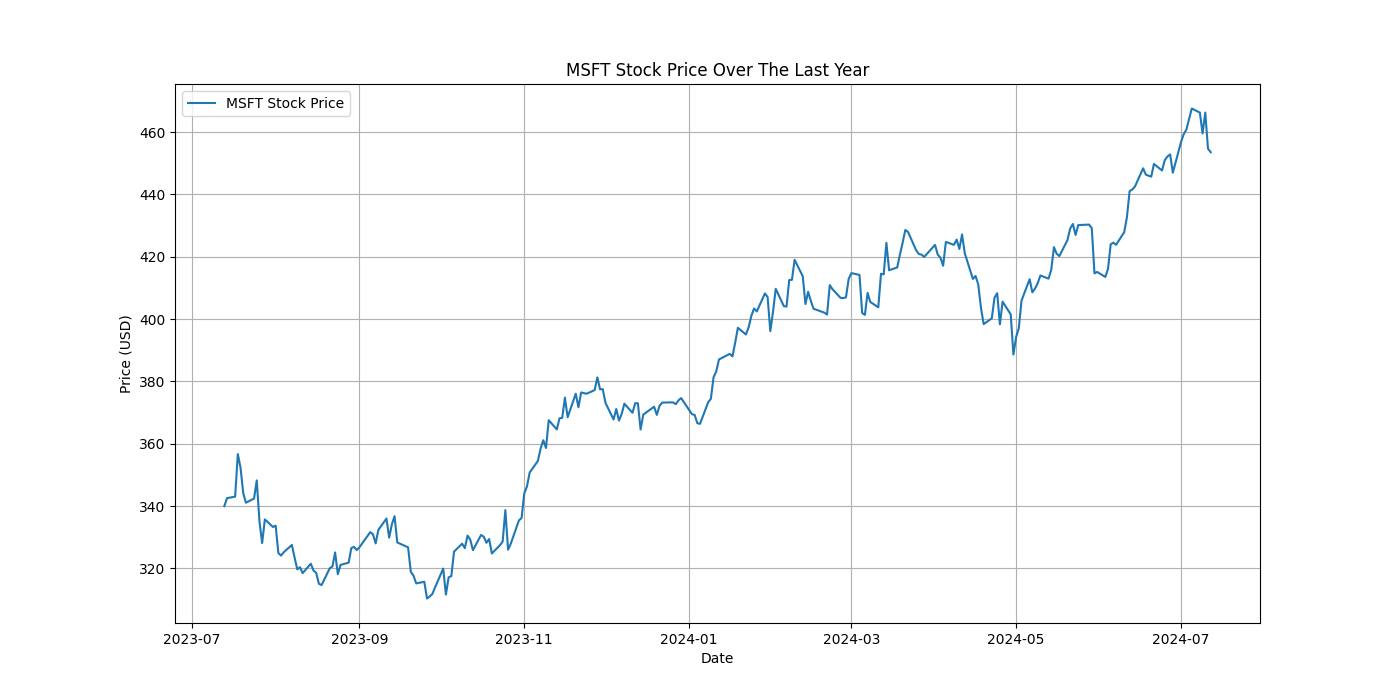

In [8]:
from IPython.display import Image

Image("groupchat/microsoft_stock_price.png")

## Using Both Agent Library and Tool Library
Now let's retrieve from both agent library and tool library while building experts for nested chat.

To run the following demo, it is required to install the dependencies and obtain BING search api and Rapid API key for tools in library to fully function. Refer to instructions [here](/docs/topics/captainagent/tool).

In [9]:
from autogen.agentchat.contrib.captain_agent import CaptainAgent
from autogen.agentchat.contrib.captain_user_proxy_agent import CaptainUserProxyAgent

nested_mode_config = {
    "autobuild_init_config": {
        "config_file_or_env": "OAI_CONFIG_LIST",
        "builder_model": "gpt-4-1106",
        "agent_model": "gpt-4-1106",
    },
    # this is used to configure the autobuild building process
    "autobuild_build_config": {
        "default_llm_config": {"temperature": 1, "top_p": 0.95, "max_tokens": 1500, "seed": 52},
        # this is used to configure the user proxy within nested chat
        "code_execution_config": {"timeout": 300, "work_dir": "groupchat", "last_n_messages": 1},
        "coding": True,
        "library_path_or_json": "captainagent_expert_library.json",
    },
    # this is used to configure the group chat
    "autobuild_tool_config": {
        "tool_root": "default",  # this will use the tool library we provide
        "retriever": "all-mpnet-base-v2",
    },
    "group_chat_config": {"max_round": 15},
    "group_chat_llm_config": general_llm_config.copy(),
}

In [15]:
# The function requires BING api key and Rapid API key to work. You can follow the instructions from readme to get one.
import os

os.environ["BING_API_key"] = "cd21c272de5542f588d8e26e95c97e99"
os.environ["RAPID_API_KEY"] = "f12b4f6c3fmshb2346ff0da5a4f2p1afe92jsn421fb8b9a71c"

## build agents
meta_agent = CaptainAgent(name="meta_agent", llm_config=general_llm_config, nested_mode="autobuild")
meta_user_proxy = CaptainUserProxyAgent(
    name="meta_user_proxy",
    nested_mode_config=nested_mode_config,
    code_execution_config={"use_docker": False},
    agent_config_save_path=None,  # If you'd like to save the created agents in nested chat for further use, specify the path here
)

query = """# Task
Your task is to solve a question given by a user.

# Question
Examine the video at https://www.youtube.com/watch?v=1htKBjuUWec.

What does Teal'c say in response to the question "Isn't that hot?"
""".strip()
result = meta_user_proxy.initiate_chat(meta_agent, message=query)

meta_user_proxy (to meta_agent):

# Task
Your task is to solve a question given by a user.

# Question
Examine the video at https://www.youtube.com/watch?v=1htKBjuUWec.

What does Teal'c say in response to the question "Isn't that hot?"

--------------------------------------------------------------------------------


meta_agent (to meta_user_proxy):

To solve this task, I will need to access the video content at the provided YouTube link, watch the specific segment where the question "Isn't that hot?" is asked, and then identify Teal'c's response.

Since I cannot directly access or watch videos, I will need to delegate this task to a human expert who can watch the video and provide the information requested.

## building_task
- [Video Content Analyst]: An expert who can access and watch the video content on YouTube. This person should be able to understand English and accurately transcribe or summarize spoken dialogue from the video.
- [Verification Expert]: A checker who can verify the accuracy of the information provided by the Video Content Analyst by cross-referencing with the video or other reliable sources.

## execution_task
## Task description
Watch the video at https://www.youtube.com/watch?v=1htKBjuUWec and identify the response given by the character Teal'c to the question "Isn't that ho

/workspaces/autogen/autogen/agentchat/conversable_agent.py:1365: UserWarning: Extracted_response from ChatCompletion(id='chatcmpl-9ka4K9X1gKpikgllyTd33CHYMwfsM', choices=[Choice(finish_reason='content_filter', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'medium'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1720888764, model='gpt-4', object='chat.completion', service_tier=None, system_fingerprint='fp_811936bd4f', usage=CompletionUsage(completion_tokens=5, prompt_tokens=544, total_tokens=549), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence'

APIProcessing_Expert (to chat_manager):

To find out what Teal'c's response is to the question "Isn't that hot?" in the video, I will retrieve the captions from the YouTube video, which is more efficient than watching the entire video to find the exact moment where the question is asked. Once we have the captions, we can search through the text for the question and find Teal'c's response.

Let's start by retrieving the captions from the YouTube video using the `get_youtube_caption` function. The video ID is `1htKBjuUWec` from the provided YouTube link.

```python
from functions import get_youtube_caption

# The video ID for the YouTube video
video_id = "1htKBjuUWec"

# Retrieve the captions for the YouTube video
captions = get_youtube_caption(video_id)
print(captions)
```

Once we have the captions, we can look for the relevant section and transcribe the response.

--------------------------------------------------------------------------------

Next speaker: Computer_terminal


>>>>>>

/workspaces/autogen/autogen/agentchat/conversable_agent.py:1365: UserWarning: Extracted_response from ChatCompletion(id='chatcmpl-9ka4yHDDD1lvceTXXEhz7FmdlOVml', choices=[Choice(finish_reason='content_filter', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'medium'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1720888804, model='gpt-4', object='chat.completion', service_tier=None, system_fingerprint='fp_811936bd4f', usage=CompletionUsage(completion_tokens=5, prompt_tokens=744, total_tokens=749), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence'

VideoTranscription_Expert (to chat_manager):

Based on the retrieved captions from the YouTube video with the ID `1htKBjuUWec`, the response to the question "Isn't that hot?" given by the character is:

"Extremely"

Please verify this transcription for accuracy by cross-referencing it with the video content around the timestamp where this line occurs to ensure that it is indeed Teal'c's response to the question in question.

--------------------------------------------------------------------------------

Next speaker: APIProcessing_Expert



/workspaces/autogen/autogen/agentchat/conversable_agent.py:1365: UserWarning: Extracted_response from ChatCompletion(id='chatcmpl-9ka5FOIYMx8AYLnPzmDy8VGk1aaAU', choices=[Choice(finish_reason='content_filter', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'medium'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1720888821, model='gpt-4', object='chat.completion', service_tier=None, system_fingerprint='fp_811936bd4f', usage=CompletionUsage(completion_tokens=5, prompt_tokens=887, total_tokens=892), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence'

APIProcessing_Expert (to chat_manager):

I will verify the transcription for accuracy by searching for the line "Isn't that hot?" in the provided captions and checking if the response "Extremely" is correctly attributed to the character Teal'c. If the context in the captions indicates that Teal'c is the one responding, then the transcription will be verified as accurate. Let's proceed with locating the dialogue in the captions and confirming the speaker.

```python
# Given the caption text from the video
caption_text = "Wow this coffee's great I was just thinking that yeah is that cinnamon chicory tea oak [Music] isn't that hot extremely"

# The line to verify
question_line = "isn't that hot"
response_line = "extremely"

# Search the captions for the question and the subsequent response
question_index = caption_text.lower().find(question_line)
response_index = caption_text.lower().find(response_line, question_index)

# Verification process
if question_index != -1 and response_index != 

/workspaces/autogen/autogen/agentchat/conversable_agent.py:1365: UserWarning: Extracted_response from ChatCompletion(id='chatcmpl-9ka5vOkOJhMqloMv5dSj0eKJ0KOG2', choices=[Choice(finish_reason='content_filter', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=None), content_filter_results={'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'medium'}, 'violence': {'filtered': False, 'severity': 'safe'}})], created=1720888863, model='gpt-4', object='chat.completion', service_tier=None, system_fingerprint='fp_811936bd4f', usage=CompletionUsage(completion_tokens=5, prompt_tokens=1178, total_tokens=1183), prompt_filter_results=[{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violenc

APIProcessing_Expert (to chat_manager):

The response to the question "Isn't that hot?" has been verified as "Extremely," confirming the accuracy of the transcription. This response directly follows the question within the provided captions, attributing the line to the character Teal'c as requested in the task. 

The task appears to be successfully completed with the response from Teal'c accurately identified and verified. If everyone is in agreement, we can consider the task completed.

--------------------------------------------------------------------------------

Next speaker: Computer_terminal

Computer_terminal (to chat_manager):

There is no code from the last 1 message for me to execute. Group chat manager should let other participants to continue the conversation. If the group chat manager want to end the conversation, you should let other participant reply me only with "TERMINATE"

--------------------------------------------------------------------------------

Next speaker

The ground truth answer to the question is 'Extremely', which the CaptainAgent answers correctly. Notably, with the assistance of tools, the agent can answer video-related questions. This shows the huge potential of tools. 